In [27]:
import pandas as pd

districts = pd.read_csv("Districts.csv")
districts.head()
# print(districts.District)
print(districts.columns)
print(districts.isnull().sum())
print(districts.isna().sum())

Index(['District', 'COVID-19 Probability'], dtype='object')
District                0
COVID-19 Probability    0
dtype: int64
District                0
COVID-19 Probability    0
dtype: int64


In [303]:
moves = pd.read_csv("Interview_move_File.csv")
moves = moves.rename({'DISTRICT': 'District'}, axis=1)
moves['DATE_KEY'] = pd.to_datetime(moves['DATE_KEY'])
# moves.head()

print(moves.columns)
print(moves.District.sort_values().unique())
print(moves.ID.sort_values().unique())
print(moves.isna().sum())
print(moves.isnull().sum())

print(moves.PROVINCE.value_counts())

moves = moves.where(moves.PROVINCE == 'TEHRAN').dropna()
print(moves.PROVINCE.value_counts())

print(max(moves.DATE_KEY))
print(min(moves.DATE_KEY))

Index(['ID', 'DATE_KEY', 'TIME_KEY', 'PROVINCE', 'District'], dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[    1     2     4 ...  9998  9999 10000]
ID          0
DATE_KEY    0
TIME_KEY    0
PROVINCE    0
District    0
dtype: int64
ID          0
DATE_KEY    0
TIME_KEY    0
PROVINCE    0
District    0
dtype: int64
TEHRAN    607169
ZANJAN       176
Name: PROVINCE, dtype: int64
TEHRAN    607169
Name: PROVINCE, dtype: int64
2021-06-22 00:00:00
2021-05-04 00:00:00


In [304]:
max_date = max(moves.DATE_KEY)

moves['LastTwoWeek'] = ((max_date - moves.DATE_KEY).dt.days <= 14).map({True:1, False:0})
moves.head()

,ID,DATE_KEY,TIME_KEY,PROVINCE,District,LastTwoWeek
0,1.0,2021-06-18,07:59:50+04:30,TEHRAN,6.0,1
1,1.0,2021-05-12,07:48:17+04:30,TEHRAN,22.0,0
2,1.0,2021-05-23,12:42:37+04:30,TEHRAN,22.0,0
3,1.0,2021-06-09,07:34:29+04:30,TEHRAN,22.0,1
4,1.0,2021-06-10,07:09:49+04:30,TEHRAN,22.0,1


In [415]:
df1 = moves.groupby(['ID', 'District']).agg(
    Total = pd.NamedAgg(column="ID", aggfunc="count"),
    LTW = pd.NamedAgg(column="LastTwoWeek", aggfunc="sum"),
)
df1 = df1.reset_index()
df2 = pd.merge(df1, districts, on=['District'], how='inner')
df2.sort_values(by='ID').head()

import numpy as np
df2['TIP'] =  1-(np.power((1-df2['COVID-19 Probability']), df2['Total'])).round(2)
df2['LTWIP'] =  1-(np.power((1-df2['COVID-19 Probability']), df2['LTW'])).round(2)

df2['P'] = df2.groupby('ID')['LTWIP'].transform('max')

df2.sort_values(by='ID').head(10)

,ID,District,Total,LTW,COVID-19 Probability,TIP,LTWIP,P
0,1.0,5.0,8,5,0.29,0.94,0.82,0.99
6186,1.0,18.0,4,1,0.26,0.70,0.26,0.99
4376,1.0,11.0,1,1,0.42,0.42,0.42,0.99
2162,1.0,6.0,6,6,0.37,0.94,0.94,0.99
7624,1.0,22.0,56,28,0.17,1.00,0.99,0.99
2163,2.0,6.0,1,0,0.37,0.37,0.00,1.00
8662,2.0,4.0,86,36,0.23,1.00,1.00,1.00
10692,4.0,1.0,15,1,0.14,0.90,0.14,0.87
16767,4.0,21.0,8,0,0.18,0.80,0.00,0.87
12451,4.0,2.0,7,7,0.25,0.87,0.87,0.87


In [416]:
r_labels = range(1, 4)
r_quartiles = pd.cut(df2['P'], 3, labels=r_labels, include_lowest=True)
df2['R'] = r_quartiles

def change(df):
    if df['R'] == 3: return 'High'
    if df['R'] == 2: return 'Moderate'
    if df['R'] == 1: return 'Low'

df2['Covid_Rank'] = df2.apply(change, axis=1)

df2.sort_values('R').head(10)

,ID,District,Total,LTW,COVID-19 Probability,TIP,LTWIP,P,R,Covid_Rank
2549,1839.0,6.0,6,0,0.37,0.94,0.00,0.00,1,Low
2307,662.0,6.0,3,0,0.37,0.75,0.00,0.00,1,Low
23356,6418.0,13.0,1,0,0.32,0.32,0.00,0.00,1,Low
26387,2232.0,19.0,4,0,0.21,0.61,0.00,0.00,1,Low
2291,588.0,6.0,2,0,0.37,0.60,0.00,0.00,1,Low
7370,7922.0,18.0,22,1,0.26,1.00,0.26,0.26,1,Low
7374,7938.0,18.0,1,1,0.26,0.26,0.26,0.26,1,Low
26377,2101.0,19.0,8,0,0.21,0.85,0.00,0.00,1,Low
26376,2079.0,19.0,1,0,0.21,0.21,0.00,0.00,1,Low
26375,2070.0,19.0,26,1,0.21,1.00,0.21,0.21,1,Low


In [418]:
print(df2.groupby('Covid_Rank')['P'].mean())

Covid_Rank
High        0.985292
Low         0.046088
Moderate    0.527077
Name: P, dtype: float64


High        31294
Low          1388
Moderate      626
Name: Covid_Rank, dtype: int64


<AxesSubplot:>

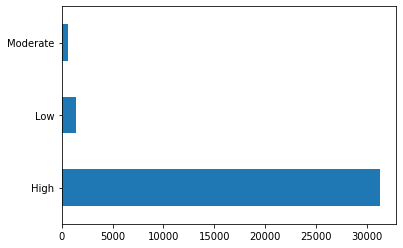

In [419]:
print(df2['Covid_Rank'].value_counts())
df2['Covid_Rank'].value_counts().plot(kind='barh')

<AxesSubplot:xlabel='District'>

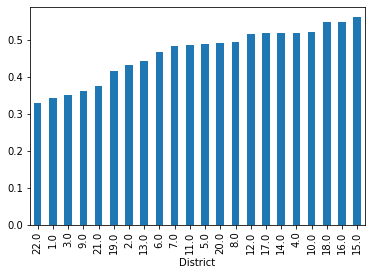

In [420]:
df2.groupby('District')['LTWIP'].mean().sort_values().plot.bar()

In [421]:
usage_file = pd.read_csv("Interview_Usage_File.csv")
print(usage_file.dtypes)
usage_file['DATE_KEY'] = pd.to_datetime(usage_file['DATE_KEY'].astype('str'))
usage_file.sort_values('DATE_KEY', ascending=True).head()

ID                 int64
DATE_KEY           int64
DATA_USAGE_MB    float64
DATA_REVENUE       int64
VOICE_USAGE        int64
VOICE_REVENUE    float64
SMS_USAGE          int64
SMS_REVENUE      float64
DEVICE_FLAG       object
dtype: object


,ID,DATE_KEY,DATA_USAGE_MB,DATA_REVENUE,VOICE_USAGE,VOICE_REVENUE,SMS_USAGE,SMS_REVENUE,DEVICE_FLAG
145567,4712,2021-04-01,0.000000,0,299,2985.016666,0,0.0,SMARTPHONE
264705,5911,2021-04-01,125.839504,0,400,5993.333333,11,1276.0,SMARTPHONE
478659,7209,2021-04-01,112.115061,0,54,0.000000,8,622.0,SMARTPHONE
478601,9599,2021-04-01,0.000000,0,5,74.916667,0,0.0,SMARTPHONE
34416,1804,2021-04-01,504.541904,0,0,0.000000,0,0.0,SMARTPHONE


In [422]:
print(usage_file.describe())

                  ID  DATA_USAGE_MB  DATA_REVENUE    VOICE_USAGE  \
count  537383.000000  537383.000000  5.373830e+05  537383.000000   
mean     5079.041570     558.488469  1.415937e+04     343.483636   
std      2877.214259    1319.862271  8.218518e+04     821.821620   
min         1.000000       0.000000  0.000000e+00       0.000000   
25%      2636.000000       0.000506  0.000000e+00       0.000000   
50%      5109.000000     143.338548  0.000000e+00      38.000000   
75%      7529.000000     684.160525  0.000000e+00     321.000000   
max     10000.000000  161641.164249  6.100000e+06   31687.000000   

       VOICE_REVENUE      SMS_USAGE    SMS_REVENUE  
count   5.373830e+05  537383.000000  537383.000000  
mean    4.319193e+03       2.695524     326.966432  
std     1.558015e+04      20.080732    2985.152831  
min     0.000000e+00       0.000000       0.000000  
25%     0.000000e+00       0.000000       0.000000  
50%     2.400000e+02       0.000000       0.000000  
75%     3.476133

In [423]:
udf1 = usage_file.groupby(['ID','DATE_KEY']).agg(
    {
        'DATA_USAGE_MB':'sum',
        'DATA_REVENUE':'sum',
        'VOICE_USAGE':'sum',
        'VOICE_REVENUE':'sum',
        'SMS_USAGE':'sum',
        'SMS_REVENUE':'sum'
    }
)

udf1['Total_Amount'] = udf1['DATA_REVENUE'] + udf1['VOICE_REVENUE'] +udf1['SMS_REVENUE']

udf1 = udf1.reset_index()
udf1.head(10)

,ID,DATE_KEY,DATA_USAGE_MB,DATA_REVENUE,VOICE_USAGE,VOICE_REVENUE,SMS_USAGE,SMS_REVENUE,Total_Amount
0,1,2021-04-17,0.0,0,653,4420.083333,39,4524.0,8944.083333
1,1,2021-04-18,0.0,0,673,7821.299999,7,696.0,8517.299999
2,1,2021-04-19,0.0,0,783,3476.133334,19,2246.0,5722.133334
3,1,2021-04-20,0.0,0,651,2682.016667,7,812.0,3494.016667
4,1,2021-04-21,0.0,0,1273,2667.033334,6,696.0,3363.033334
5,1,2021-04-22,0.0,0,171,2562.150000,13,1508.0,4070.150000
6,1,2021-04-23,0.0,0,300,0.000000,6,696.0,696.000000
7,1,2021-04-24,0.0,0,297,1603.216667,3,348.0,1951.216667
8,1,2021-04-25,0.0,0,606,4150.383334,3,232.0,4382.383334
9,1,2021-04-26,0.0,0,265,3970.583333,4,464.0,4434.583333


In [424]:
snapshot_date = max(udf1['DATE_KEY'])
udf1['Purchase_FLAG'] = (udf1['Total_Amount'] > 0).map({False:0, True:1})

datamart = udf1.groupby('ID').agg(
    {
        'DATE_KEY': lambda x: (snapshot_date - x.max()).days,
        'Purchase_FLAG': 'count',
        'Total_Amount': 'sum'
    }
).round(1)

datamart.rename(

    columns={'DATE_KEY':'Recency', 'Purchase_FLAG': 'Frequency', 'Total_Amount':'Monetary'}, 
    inplace=True
)

print(datamart)

       Recency  Frequency   Monetary
ID                                  
1            1         62   488848.7
2            2         56   838050.1
3           42          1        0.0
4            1         12     3007.8
5            1         82  2277936.3
...        ...        ...        ...
9996         1         82  5003041.6
9997         1         76     6634.0
9998         1         82      838.0
9999         1         39  1521477.2
10000        1         81  2049173.4

[10000 rows x 3 columns]


In [426]:
r_labels = range(3, 0, -1)
r = pd.cut(datamart['Recency'], 3, labels=r_labels)
datamart['R'] = r

f_labels = range(1, 4)
f = pd.cut(datamart['Frequency'], 3, labels=f_labels)
datamart['F'] = f

m_labels = range(1, 4)
m = pd.cut(datamart['Monetary'], 3, labels=m_labels)
datamart['M'] = m

def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

datamart['RFM_Score'] = datamart[['R', 'F' ,'M']].sum(axis=1)
datamart.sort_values('RFM_Score')
# datamart.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
ID,,,,,,,,
9499,53,1,0.0,1,1,1,111,3
8344,50,20,797949.6,1,1,1,111,3
4176,45,1,0.0,1,1,1,111,3
4484,45,2,0.0,1,1,1,111,3
6662,49,1,580.0,1,1,1,111,3
...,...,...,...,...,...,...,...,...
7203,1,82,12400000.0,3,3,3,333,9
9939,1,81,11700000.0,3,3,3,333,9
4630,1,82,12179502.4,3,3,3,333,9


In [427]:
data = datamart.groupby('RFM_Score').agg(
    {
        'Recency':'mean',
        'Frequency': 'mean',
        'Monetary': 'mean'
    }
).round(1)
data = data.reset_index()
data.head(10)

,RFM_Score,Recency,Frequency,Monetary
0,3,50.9,5.9,56490.6
1,4,31.8,9.6,85514.1
2,5,7.9,17.1,125259.6
3,6,3.1,42.6,390429.1
4,7,1.3,76.4,1516913.0
5,8,1.0,80.3,7009505.3
6,9,1.0,81.8,13021024.3


<AxesSubplot:xlabel='RFM_Score'>

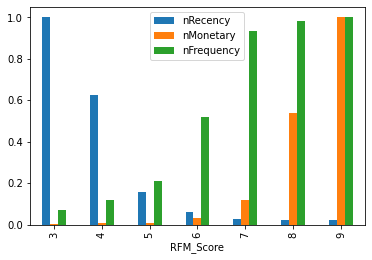

In [428]:
# import seaborn as sns
# sns.barplot(x='RFM_Score', y='Recency', hue='RFM_Score', data=data, saturation=0.9)

data['nRecency'] = data.Recency/max(data.Recency)
data['nMonetary'] = data.Monetary/max(data.Monetary)
data['nFrequency'] = data.Frequency/max(data.Frequency)

data.plot(x="RFM_Score", y=["nRecency", "nMonetary", "nFrequency"], kind="bar")

In [429]:
def segment_name(df):
    if df['RFM_Score'] >= 8: return 'Gold'
    if df['RFM_Score'] >= 6 and df['RFM_Score'] < 8: return 'Silver'
    if df['RFM_Score'] < 6: return 'Bronze'

datamart['General_Segment'] = datamart.apply(segment_name, axis=1)
datamart.sort_values('ID').head(10)

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,General_Segment
ID,,,,,,,,,
1,1,62,488848.7,3,3,1,331,7,Silver
2,2,56,838050.1,3,3,1,331,7,Silver
3,42,1,0.0,1,1,1,111,3,Bronze
4,1,12,3007.8,3,1,1,311,5,Bronze
5,1,82,2277936.3,3,3,1,331,7,Silver
6,1,44,304520.2,3,2,1,321,6,Silver
7,1,82,679526.1,3,3,1,331,7,Silver
8,3,3,10025.9,3,1,1,311,5,Bronze
9,1,51,498260.3,3,2,1,321,6,Silver


In [431]:
f1 = pd.merge(datamart, df2, on='ID')
f2 = f1[['ID', 'General_Segment', 'Covid_Rank']].drop_duplicates()
f2.head(10)

,ID,General_Segment,Covid_Rank
0,1,Silver,High
5,2,Silver,High
7,4,Bronze,High
13,5,Silver,High
20,6,Silver,High
25,7,Silver,High
28,9,Silver,High
30,10,Bronze,Low
31,11,Silver,High
34,12,Bronze,High


In [436]:
agg = f2.groupby(['General_Segment', 'Covid_Rank']).count()
agg.rename({'ID':'Count'})
agg = agg.reset_index()
agg.head(20)

,General_Segment,Covid_Rank,ID
0,Bronze,High,1696
1,Bronze,Low,483
2,Bronze,Moderate,112
3,Gold,High,96
4,Gold,Low,3
5,Gold,Moderate,2
6,Silver,High,6406
7,Silver,Low,254
8,Silver,Moderate,117
